In [1]:
import pandahouse
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import hashlib

import swifter

from scipy. stats import ttest_ind

Загрузим данные из clickhouse:

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20240120',
    'user':'student',
    'password':'dpo_python_2020'
}

query = '''
select user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
where (toDate(time) >= '2023-12-22' and toDate(time) <= '2023-12-28') and (exp_group IN [2, 3])
group by exp_group, user_id
'''

df = pandahouse.read_clickhouse(query, connection=connection)

In [3]:
df.head()

,user_id,exp_group,likes,views,ctr
0,115383,3,38,248,0.153226
1,10326,3,24,132,0.181818
2,123580,3,25,122,0.204918
3,131473,2,19,98,0.193878
4,23985,2,12,44,0.272727


In [4]:
df.user_id.nunique()

16787

In [5]:
df.groupby('exp_group')['user_id'].nunique()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

Всего у нас в двух экспериментальных группах 16787 пользователей, в каждой из них примерно одинаковое количество: во 2 - 8362, в 3 - 8425.

Разобьем наш датафрейм на 2:

In [6]:
group_1 = df[df['exp_group']==2]
group_2 = df[df['exp_group']==3]

In [7]:
group_1.head(3)

,user_id,exp_group,likes,views,ctr
3,131473,2,19,98,0.193878
4,23985,2,12,44,0.272727
5,24523,2,2,10,0.200000


In [8]:
group_2.head(3)

,user_id,exp_group,likes,views,ctr
0,115383,3,38,248,0.153226
1,10326,3,24,132,0.181818
2,123580,3,25,122,0.204918


Зададим массив значений p-values, которые получим в цикле. Для этого сформируем подвыборки без повторений в 500 юзеров из нужных нам групп (2 и 3).

In [9]:
p_values = []

In [10]:
for i in range(10000):
    
    group_1_new = group_1.ctr.sample(500, replace=False)
    group_2_new = group_2.ctr.sample(500, replace=False)
    p_value = ttest_ind(group_1_new, group_2_new, equal_var=False)[1]
    p_values.append(p_value)

p_values = pd.Series(p_values)

In [11]:
p_values.head()

0    0.741211
1    0.653876
2    0.884399
3    0.461495
4    0.473062
dtype: float64

Построим гистограмму распределения получившихся 10000 p-values:

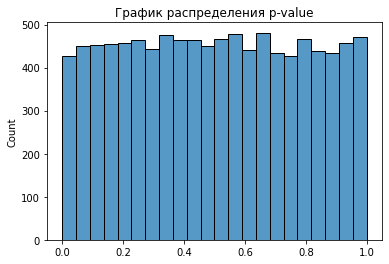

In [12]:
sns.histplot(p_values)
plt.title('График распределения p-value')
plt.show()

По графику видно, что распределение равномерно, нет каких-либо сильных отклонений.

Посчитаем, какой процент p-value оказался меньше либо равен 0.05:

In [13]:
p_values[p_values <= 0.05].count() / p_values.count() * 100

4.72

Всего в 4.75% случаем p-value оказывается меньше либо равен 0.05.

**Вывод:**  
Мы провели симуляцию 10000 А/А-тестов с данными из двух экспериментальных групп (2 и 3) за период с 22 по 28 декабря 2023. На каждой итерации были сформированы выборки по 500 уникальных пользователей. Сравнив эти подвыборки t-тестом, можно сделать вывод, что наша система сплитования работает корректно, ключевая метрика (ctr) в целом не отличается между группами.